In [1]:
import dgl

import torch
import torch.nn as nn

import pytorch_lightning as pl

import networkx as nx

from data import pert_S

from dgl.nn import GATConv, GraphConv

import numpy as np

import matplotlib.pyplot as plt

In [2]:
def get_data(dataset_class):
    dataset = getattr(dgl.data, dataset_class)(verbose=False)
    g = dataset[0]
    num_class = dataset.num_classes
    g = g.int().to('cuda')

    # get node feature
    feat = g.ndata['feat']#.to("cuda")

    # get data split
    train_mask = g.ndata['train_mask']#.to("cuda")
    val_mask = g.ndata['val_mask']#.to("cuda")
    test_mask = g.ndata['test_mask']#.to("cuda")

    # get labels
    label = g.ndata['label']#.to("cuda")
    N = g.number_of_nodes()
    n_feat = feat.shape[1]

    S = g.adj().cpu().to_dense().numpy()

    return S, feat, label, n_feat, num_class, train_mask, val_mask, test_mask

In [3]:
# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, model, pert, train_mask, val_mask, test_mask):
        super().__init__()
        self.save_hyperparameters("pert")
        self.model = model

        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask

    def training_step(self, batch, batch_idx):

        x, y = batch
        y_hat = self.model(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        # Compute prediction
        pred = y_hat.argmax(1)

        # Compute accuracy on training/validation/test
        train_acc = (pred[self.train_mask] == y[self.train_mask]).float().mean()
        val_acc = (pred[self.val_mask] == y[self.val_mask]).float().mean()
        test_acc = (pred[self.test_mask] == y[self.test_mask]).float().mean()

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [4]:
n_epochs = 200
lr = 5e-3
wd = 5e-4
eval_freq = 20

In [5]:
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def test(model, g, feat, label, train_mask, val_mask, test_mask, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = torch.nn.CrossEntropyLoss()

    loss_train, acc_train, acc_test = [torch.zeros(n_epochs) for _ in range(3)]

    for i in range(n_epochs):
        model.train()
        y_hat = model(g, feat)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = loss_fn(y_hat[train_mask], label[train_mask])

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Compute accuracy on training/validation/test
        train_acc = evaluate(g, feat, label, train_mask, model)
        val_acc = evaluate(g, feat, label, val_mask, model)
        test_acc = evaluate(g, feat, label, test_mask, model)

        loss_train[i] = loss.detach().cpu().item()
        acc_train[i] = train_acc
        acc_test[i] = test_acc

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss Train: {loss_train[i]} - Acc Train: {acc_train[i]} - Acc Val: {val_acc} - Acc Test: {acc_test[i]}", flush=True)

    return loss_train, acc_train, acc_test

In [6]:
hid_dim_gcn = 16

hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [7]:
EXPS = [
    {
        "dataset": "Cora",
        "layer": "GCN",
        "legend": "Cora-GCN",
        "fmt": "d-"
    },
    {
        "dataset": "Citeseer",
        "layer": "GCN",
        "legend": "Citeseer-GCN",
        "fmt": "v-"
    },
    {
        "dataset": "Cora",
        "layer": "GAT",
        "legend": "Cora-GAT",
        "fmt": "s-"
    },
    {
        "dataset": "Citeseer",
        "layer": "GAT",
        "legend": "Citeseer-GAT",
        "fmt": "v-"
    },
]

In [8]:
class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads, gat_params):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads, **gat_params)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1, **gat_params)
        self.nonlin = nn.ELU()

    def forward(self, graph, h):
        h = self.layer1(graph, h)
        # concatenate
        h = h.flatten(1)
        h = self.nonlin(h)
        h = self.layer2(graph, h)
        return h.squeeze()

In [9]:
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCN, self).__init__()
        self.layer1 = GraphConv(in_dim, hidden_dim)
        self.layer2 = GraphConv(hidden_dim, out_dim)
        self.nonlin = nn.ELU()

    def forward(self, graph, h):
        h = self.layer1(graph, h)
        h = self.nonlin(h)
        h = self.layer2(graph, h)
        return h

In [10]:
perts = [0., 0.05, 0.1, 0.15, 0.2, 0.25]

n_graphs = 25

accs_test = np.zeros((n_graphs, len(EXPS), len(perts)))
for i, p in enumerate(perts):

    for j, exp in enumerate(EXPS):

        S, feat, label, in_dim, out_dim, train_mask, val_mask, test_mask = get_data(exp['dataset'] + "GraphDataset")

        print(f"Starting pert {p} of exp {exp['dataset']} - {exp['layer']}: ", end="")

        for n in range(n_graphs):
            print(f"{n+1} ", end="")
            
            S_pert = pert_S(S.copy(), eps=p)
            if p == 0.:
                assert np.all(S_pert == S)

            g = dgl.from_networkx(nx.from_numpy_array(S_pert)).add_self_loop().to('cuda')

            if exp['layer'] == "GCN":
                model = GCN(in_dim, hid_dim_gcn, out_dim).to('cuda')
            elif exp['layer'] == "GAT":
                model = GAT(in_dim, hid_dim_gat, out_dim, num_heads, gat_params).to('cuda')

            # model training
            #train(g, feat, label, [train_mask, val_mask, test_mask], model)
            loss_train, acc_train, acc_test = test(model, g, feat, label, train_mask, val_mask, test_mask, False)

            accs_test[n, j, i] = acc_test[-1]
        print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[j,i]}")

Starting pert 0.0 of exp Cora - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.8129200005531311
Starting pert 0.0 of exp Citeseer - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.7061999988555908
Starting pert 0.0 of exp Cora - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.8215599942207337
Starting pert 0.0 of exp Citeseer - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.7020799970626831
Starting pert 0.05 of exp Cora - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.7969999980926513
Starting pert 0.05 of exp Citeseer - GCN: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Test: 0.6934400010108948
Starting pert 0.05 of exp Cora - GAT: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 DONE - Accuracy Te

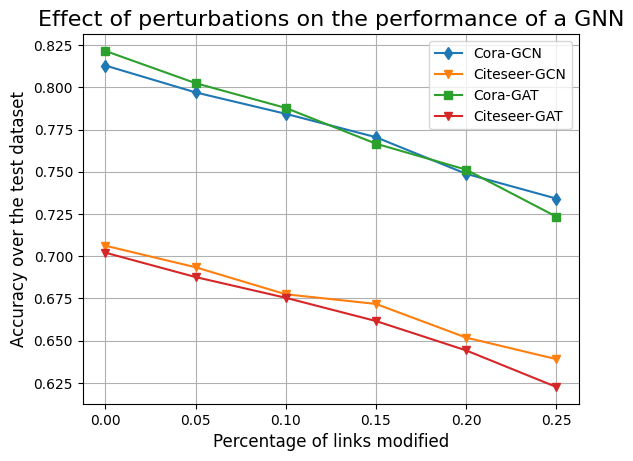

In [11]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, accs_test.mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Accuracy over the test dataset", fontsize=12)
plt.title("Effect of perturbations on the performance of a GNN", fontsize=16)
plt.legend()
plt.grid()